In [4]:
import pandas as pd
import numpy as np


In [5]:
Merged_data = pd.read_excel('Merged_data.xlsx')
Merged_data.set_index('Date', inplace=True)

In [6]:
Merged_data.isnull().sum()
Merged_data.fillna(method='ffill', inplace=True)

C:\Users\Yin Jianing\AppData\Local\Temp\ipykernel_24272\19555969.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Merged_data.fillna(method='ffill', inplace=True)


In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Merged_data_scaled = scaler.fit_transform(Merged_data)

In [8]:
Merged_data_scaled = pd.DataFrame(Merged_data_scaled, columns=Merged_data.columns, index=Merged_data.index)
Merged_data_scaled

,temperature_2m (°C),relative_humidity_2m (%),precipitation (mm),et0_fao_evapotranspiration (mm),wind_speed_10m (km/h),wind_gusts_10m (km/h),soil_temperature_0_to_7cm (°C),soil_moisture_0_to_7cm (m³/m³),direct_radiation (W/m²),Turbidity
Date,,,,,,,,,,
2020-12-31 15:00:00,0.284165,0.7250,0.0,0.063291,0.187023,0.184783,0.238342,0.828221,0.069797,0.011305
2020-12-31 16:00:00,0.271150,0.8125,0.0,0.025316,0.106870,0.164032,0.230570,0.828221,0.031726,0.013732
2020-12-31 17:00:00,0.229935,0.9250,0.0,0.012658,0.139313,0.078063,0.215026,0.825153,0.003807,0.013449
2020-12-31 18:00:00,0.214751,0.9375,0.0,0.000000,0.135496,0.075099,0.199482,0.822086,0.000000,0.011833
2020-12-31 19:00:00,0.195228,0.9625,0.0,0.000000,0.160305,0.084980,0.183938,0.819018,0.000000,0.010650
...,...,...,...,...,...,...,...,...,...,...
2023-12-30 05:00:00,0.347072,0.8750,0.0,0.012658,0.410305,0.351779,0.313472,0.852761,0.000000,0.011957
2023-12-30 06:00:00,0.347072,0.8750,0.0,0.012658,0.408397,0.344862,0.308290,0.852761,0.000000,0.010460
2023-12-30 07:00:00,0.342733,0.8875,0.0,0.000000,0.362595,0.341897,0.305699,0.849693,0.000000,0.010873


In [9]:
import numpy as np

def create_multivariate_sequences(data, window_size, target_index):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])                 # shape: (window_size, num_features)
        y.append(data[i + window_size, target_index])     # predict turbidity
    return np.array(X), np.array(y)

window_size = 24  # use past 24 time steps
target_index = Merged_data_scaled.columns.get_loc('Turbidity')
X, y = create_multivariate_sequences(Merged_data_scaled.values, window_size, target_index)

print("X shape:", X.shape)  # (samples, window_size, features)
print("y shape:", y.shape)  # (samples,)


X shape: (26227, 24, 10)
y shape: (26227,)


In [10]:
train_size = int(0.8 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

model = Sequential([
    GRU(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(1)  # output = predicted turbidity
])

model.compile(loss='mse', optimizer='adam')
model.summary()


C:\Users\Yin Jianing\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        14,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,657 (57.25 KB)

 Trainable params: 14,657 (57.25 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.4937e-04 - val_loss: 2.6020e-04
Epoch 2/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.9456e-04 - val_loss: 1.4307e-04
Epoch 3/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.0034e-04 - val_loss: 1.4715e-04
Epoch 4/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.5285e-04 - val_loss: 1.2862e-04
Epoch 5/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.3357e-04 - val_loss: 1.3405e-04
Epoch 6/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.7756e-04 - val_loss: 1.2303e-04
Epoch 7/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.4105e-04 - val_loss: 1.2721e-04
Epoch 8/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.3434e-04 - val_loss: 1.2209e-04
Epoch 9/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.3628e-04 - val_loss: 1.6873e-04
Epoch 10/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.0758e-04 - val_loss: 1.2870e-04


In [14]:
# Predict
y_pred = model.predict(X_test)

# Inverse scale turbidity only
# Create dummy array to inverse only turbidity (keep shape)
y_pred_full = np.zeros((len(y_pred), Merged_data_scaled.shape[1]))
y_test_full = np.zeros((len(y_test), Merged_data_scaled.shape[1]))

# Fill turbidity column with predictions and ground truth
y_pred_full[:, target_index] = y_pred.flatten()
y_test_full[:, target_index] = y_test

# Inverse transform
y_pred_inv = scaler.inverse_transform(y_pred_full)[:, target_index]
y_test_inv = scaler.inverse_transform(y_test_full)[:, target_index]


164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Test RMSE: 0.95


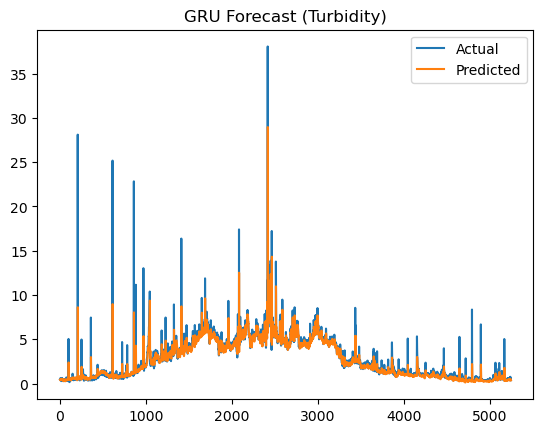

In [15]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

rmse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = rmse**0.5
print(f"Test RMSE: {rmse:.2f}")

plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.legend()
plt.title("GRU Forecast (Turbidity)")
plt.show()


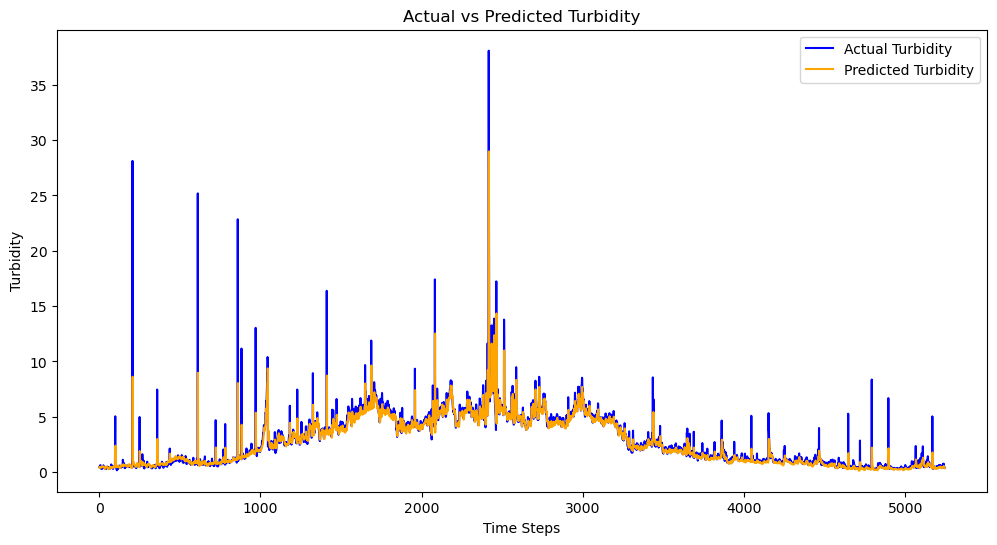

In [16]:
# Plot actual vs predicted turbidity on training set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Turbidity', color='blue')
plt.plot(y_pred_inv, label='Predicted Turbidity', color='orange')
plt.title('Actual vs Predicted Turbidity')
plt.xlabel('Time Steps')
plt.ylabel('Turbidity')
plt.legend()
plt.show()
